# IMPORTS

In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import folium
import folium.plugins as plugins
import imageio

import scipy.stats as stats
from datetime import datetime, timedelta
from scipy.stats import pearsonr

# LOAD DATA

In [3]:
full_fires_df = pd.read_csv('../data/California_Fire_Incidents.csv')
full_fires_df.head(1)

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,...,SearchKeywords,Started,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders
0,257314.0,False,Stanislaus National Forest/Yosemite National Park,NaN,2013,True,/incidents/2013/8/17/rim-fire/,NaN,NaN,Tuolumne,...,"Rim Fire, Stanislaus National Forest, Yosemite...",2013-08-17T15:25:00Z,Finalized,NaN,NaN,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,2013-09-06T18:30:00Z,NaN


In [4]:
full_fires_df.shape

(1636, 40)

In [5]:
full_fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AcresBurned           1633 non-null   float64
 1   Active                1636 non-null   bool   
 2   AdminUnit             1636 non-null   object 
 3   AirTankers            28 non-null     float64
 4   ArchiveYear           1636 non-null   int64  
 5   CalFireIncident       1636 non-null   bool   
 6   CanonicalUrl          1636 non-null   object 
 7   ConditionStatement    284 non-null    object 
 8   ControlStatement      111 non-null    object 
 9   Counties              1636 non-null   object 
 10  CountyIds             1636 non-null   object 
 11  CrewsInvolved         171 non-null    float64
 12  Dozers                123 non-null    float64
 13  Engines               191 non-null    float64
 14  Extinguished          1577 non-null   object 
 15  Fatalities           

# DATA CLEANING

In [6]:
full_fires_df['StartDate'] = full_fires_df['Started'].apply(lambda x: pd.to_datetime(x[:10]))
# creates a date column for when the fire started.
full_fires_df['StartYear'] = full_fires_df['Started'].apply(lambda x: int(x[:4]))
# creates a year column for when the fire started.
full_fires_df['StartMonth'] = full_fires_df['Started'].apply(lambda x: int(x[5:7]))
# creates a month column for when the fire started.

In [7]:
ca_fires_df = full_fires_df[['UniqueId', 'Name', 'Counties', 'StartYear', 'StartMonth', 'StartDate', 'AcresBurned', 'Latitude', 'Longitude', 'MajorIncident']]
ca_fires_df.shape
# creates dataframe that I will work out of.

(1636, 10)

In [8]:
ca_fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UniqueId       1636 non-null   object        
 1   Name           1636 non-null   object        
 2   Counties       1636 non-null   object        
 3   StartYear      1636 non-null   int64         
 4   StartMonth     1636 non-null   int64         
 5   StartDate      1636 non-null   datetime64[ns]
 6   AcresBurned    1633 non-null   float64       
 7   Latitude       1636 non-null   float64       
 8   Longitude      1636 non-null   float64       
 9   MajorIncident  1636 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 116.8+ KB


In [9]:
ca_fires_df = ca_fires_df.dropna(axis=0, subset=['AcresBurned'])
ca_fires_df = ca_fires_df[ca_fires_df['AcresBurned'] != 0]
ca_fires_df.shape
# removes zeros and null values from AcresBurned column.

(1605, 10)

In [10]:
ca_fires_df = ca_fires_df[(ca_fires_df['Latitude'] >= 32) & (ca_fires_df['Latitude'] <= 42) & (ca_fires_df['Longitude'] <= -114) & (ca_fires_df['Longitude'] >= -126)]
ca_fires_df.shape
# removes observations that are not in CA.

(1439, 10)

In [11]:
ca_fires_df[(ca_fires_df['Latitude'] >= 38) & (ca_fires_df['Latitude'] <= 41) & (ca_fires_df['Longitude'] <= -115) & (ca_fires_df['Longitude'] >= -118)]
ca_fires_df[ca_fires_df['Counties'] == 'State of Nevada']
# locates which observations were falling in Nevada.

,UniqueId,Name,Counties,StartYear,StartMonth,StartDate,AcresBurned,Latitude,Longitude,MajorIncident
1424,3086ac2b-bbb3-4321-81e3-3cfdb9e571e9,Jasper Fire,State of Nevada,2019,7,2019-07-13,1165.0,39.631945,-119.769881,False


In [12]:
ca_fires_df = ca_fires_df[ca_fires_df['Counties'] != 'State of Nevada']
ca_fires_df = ca_fires_df[ca_fires_df['Name'] != 'Tram Fire']
ca_fires_df.shape
# removes observations that are in Nevada.

(1437, 10)

In [13]:
ca_fires_df = ca_fires_df[ca_fires_df['StartYear'] >= 2013]
ca_fires_df.shape
# removes observations that are not in the years 2013-2019.

(1435, 10)

In [14]:
ca_fires_df['UniqueId'].nunique()
# returns number of unique fires.

1410

In [15]:
ca_fires_df = ca_fires_df.groupby('UniqueId').max().reset_index()
ca_fires_df.shape
# removes duplicate records of fires.

(1410, 10)

In [16]:
ca_fires_df.head(1)

,UniqueId,Name,Counties,StartYear,StartMonth,StartDate,AcresBurned,Latitude,Longitude,MajorIncident
0,00089805-cdee-4607-8b67-1653bee463bc,Gulch Fire,Modoc,2014,7,2014-07-03,1469.0,41.489,-120.904,True


In [17]:
ca_fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UniqueId       1410 non-null   object        
 1   Name           1410 non-null   object        
 2   Counties       1410 non-null   object        
 3   StartYear      1410 non-null   int64         
 4   StartMonth     1410 non-null   int64         
 5   StartDate      1410 non-null   datetime64[ns]
 6   AcresBurned    1410 non-null   float64       
 7   Latitude       1410 non-null   float64       
 8   Longitude      1410 non-null   float64       
 9   MajorIncident  1410 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 100.6+ KB


In [18]:
ca_fires_df.describe()

,StartYear,StartMonth,AcresBurned,Latitude,Longitude
count,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000
mean,2016.807801,7.400709,3247.733333,37.223930,-120.274294
std,1.803497,1.749906,19507.818882,2.551992,2.003783
min,2013.000000,1.000000,2.000000,32.557546,-124.196290
25%,2016.000000,6.000000,35.250000,34.906157,-121.848938
50%,2017.000000,7.000000,100.000000,37.414110,-120.695931
75%,2018.000000,9.000000,400.000000,39.246458,-118.731552
max,2019.000000,12.000000,410203.000000,41.999341,-114.572650


# EXPLORATORY DATA ANALYSIS

## Line Graphs

In [ ]:
num_fires = ca_fires_df.groupby('StartYear')['AcresBurned'].count()
sum_acres = ca_fires_df.groupby('StartYear')['AcresBurned'].sum()
median_acres = ca_fires_df.groupby('StartYear')['AcresBurned'].median()
max_acres = ca_fires_df.groupby('StartYear')['AcresBurned'].max()
years = sorted(ca_fires_df['StartYear'].unique())

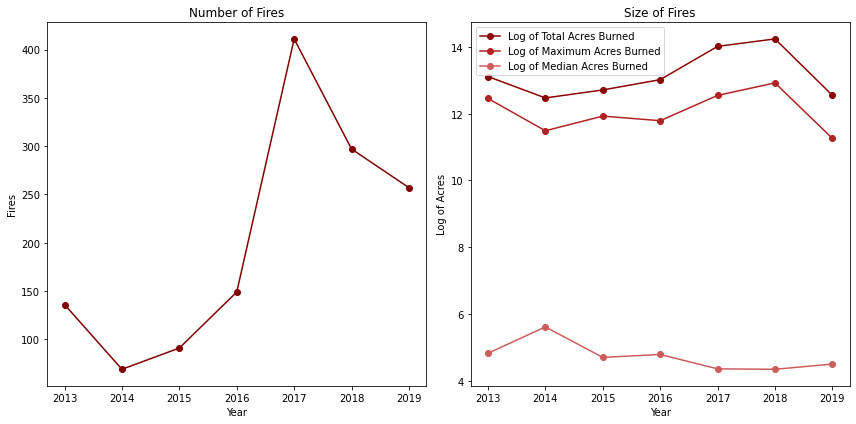

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(years, num_fires, marker='o', color='maroon')
ax[0].set_title('Number of Fires')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Fires')

ax[1].plot(years, np.log(sum_acres), marker='o', color='darkred', label='Log of Total Acres Burned')
ax[1].plot(years, np.log(max_acres), marker='o', color='firebrick', label='Log of Maximum Acres Burned')
ax[1].plot(years, np.log(median_acres), marker='o', color='indianred', label='Log of Median Acres Burned')
ax[1].set_title('Size of Fires')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Log of Acres')
ax[1].legend()

plt.tight_layout()
plt.show()
# fig.savefig('../img/num-size-line-plots.png')

## Interactive Map

In [33]:
df_copy = ca_fires_df.copy()
df_years_list = []
for year in df_copy['StartYear'].sort_values().unique():
    df_years_list.append(df_copy.loc[df_copy['StartYear']==year, ['Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())
# creates a list of lists where each element is a year and each element in that list element contains the latitudes and longitudes of each fire.
    
m = folium.Map(location=[34.0522, -118.2437], zoom_start=5)
plugins.HeatMapWithTime(df_years_list, index=[2013, 2014, 2015, 2016, 2017, 2018, 2019], 
                        radius=5, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(m)
m

In [23]:
# Create gif of interactive map.
images = []
filenames = ['../img/2013.png', '../img/2014.png', '../img/2015.png', '../img/2016.png', '../img/2017.png', '../img/2018.png', '../img/2019.png']
with imageio.get_writer('../img/num-fires.gif', mode='I', duration=1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

,StartYear,StartMonth,AcresBurned
0,2013,2,406.0
1,2013,4,379.0
2,2013,5,53957.0
3,2013,6,5127.0
4,2013,7,77082.0
...,...,...,...
59,2019,7,20463.0
60,2019,8,15129.0
61,2019,9,101251.0
62,2019,10,119814.0


In [42]:
grouped_acres_sum = ca_fires_df.groupby(['StartYear', 'StartMonth']).sum('AcresBurned')['AcresBurned'].reset_index()
grouped_acres_sum

In [24]:
def parse_grouped_sums(grouped_df, year_lst):
    '''
    Creates a list of dataframes parsed by year.
    Parameters: grouped dataframe, list of years
    Returns: list of dataframes
    '''
    parse_lst = []
    
    for year in year_lst:
        parse_lst.append(grouped_df[grouped_df['StartYear']==year])
    return parse_lst 

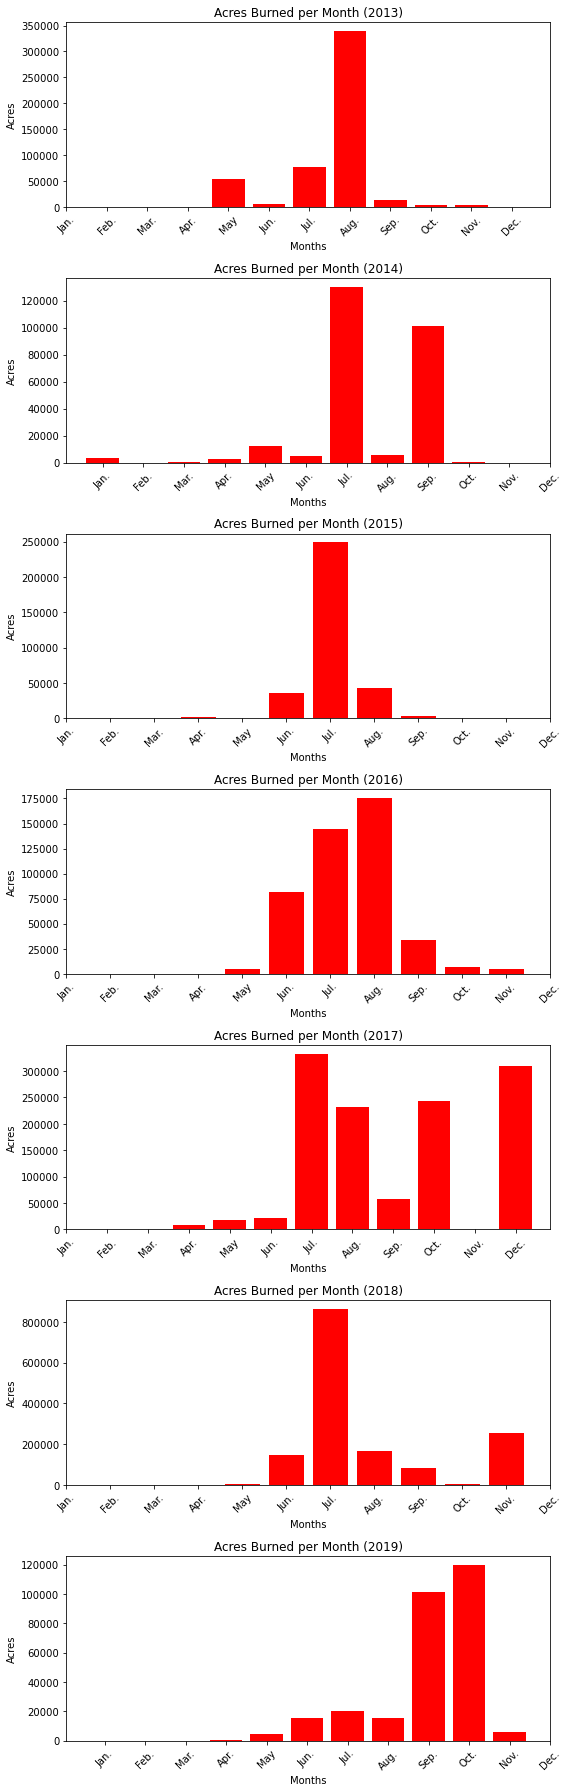

In [25]:
year_lst = list(range(2013, 2020))
df_lst = parse_grouped_sums(grouped_acres_sum, year_lst)

month_labels = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.']
fig, axs = plt.subplots(7, 1, figsize=(8, 25))

for idx, ax in enumerate(axs.flatten()):
    ax.bar(df_lst[idx]['StartMonth'], height=df_lst[idx]['AcresBurned'], color='red')
        
    ax.set_xticks(list(range(1, 13)))
    ax.set_xticklabels(month_labels, rotation=45)
        
    ax.set_title(f'Acres Burned per Month ({year_lst[idx]})')
    ax.set_xlabel('Months')
    ax.set_ylabel('Acres')
    fig.savefig('months-bar-plots.png')
    
fig.tight_layout()
plt.show()



In [26]:
grouped_month = ca_fires_df.groupby(['StartMonth', 'StartYear'])['AcresBurned'].sum()

In [27]:
grouped_month

StartMonth  StartYear
1           2014           3256.0
            2019             30.0
2           2013            406.0
            2015            200.0
            2018           2120.0
                           ...   
11          2017            599.0
            2018         257059.0
            2019           6109.0
12          2013             40.0
            2017         308889.0
Name: AcresBurned, Length: 64, dtype: float64

In [28]:
ca_fires_df.head()

,UniqueId,Name,Counties,StartYear,StartMonth,StartDate,AcresBurned,Latitude,Longitude,MajorIncident
0,00089805-cdee-4607-8b67-1653bee463bc,Gulch Fire,Modoc,2014,7,2014-07-03,1469.0,41.489000,-120.904000,True
1,0089d3c4-c554-46e1-8eb9-af95e4dfae0c,Toro Fire,Riverside,2019,8,2019-08-05,94.0,33.740219,-117.333728,False
2,00a13d84-415e-4106-aa31-2e664ed9eabf,Sky Fire,Shasta,2017,7,2017-07-29,17.0,40.692590,-122.173840,False
3,00e6d6d5-f168-45fa-817a-f7758a5170b7,Easy Fire,Ventura,2019,10,2019-10-30,1806.0,34.282179,-118.803389,False
4,01018620-8f10-4de0-a7e6-78cc9a77cc9a,Curie Fire,Santa Clara,2018,7,2018-07-10,70.0,37.225450,-121.791890,False


In [29]:
ca_fires_lst = ca_fires_df[['StartYear', 'StartMonth', 'AcresBurned']].values.tolist()
ca_fires_lst[0]

[2014.0, 7.0, 1469.0]

In [30]:
def month_counter(lst, year):
    '''
    Creates a dictionary containing the counts for each month in a particular year for ca_fires_df.
    Parameters: integer year
    Returns: dictionary
    '''
    
    months_dct = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
    
    for elem in lst:
        if int(elem[0]) == year:
            if int(elem[1] in months_dct.keys()):
                months_dct[int(elem[1])] += int(elem[2])
            
    return months_dct

In [31]:
def apply_month_counter(fire_lst, year_lst):
    '''
    Applies the previous month_counter() to a list of years.
    Parameters: list of integer years
    Returns: list of dictionaries where each dictionary represents the distribution of months per year
    '''
    
    dct_lst = [month_counter(fire_lst, year) for year in year_lst]
    
    return dct_lst

In [32]:
year_lst = [2013, 2014, 2015, 2016, 2017, 2018, 2019]
fires_dct_lst = apply_month_counter(ca_fires_lst, year_lst)
fires_dct_lst[0]

{1: 0,
 2: 406,
 3: 0,
 4: 379,
 5: 53957,
 6: 5127,
 7: 77082,
 8: 339125,
 9: 12550,
 10: 3116,
 11: 4281,
 12: 40}

In [33]:
counts_lst = []
for dct in fires_dct_lst:
    val_lst = []
    for val in dct.values():
        val_lst.append(val)
    counts_lst.append(val_lst)
counts_lst

[[0, 406, 0, 379, 53957, 5127, 77082, 339125, 12550, 3116, 4281, 40],
 [3256, 0, 582, 2331, 12233, 5156, 130272, 5906, 101564, 48, 0, 0],
 [0, 200, 0, 1186, 275, 35234, 248842, 42580, 2680, 795, 50, 0],
 [0, 0, 0, 30, 5062, 81251, 144657, 175505, 33702, 6698, 4852, 0],
 [0, 0, 0, 8802, 18518, 21455, 333125, 232442, 57889, 242626, 599, 308889],
 [0, 2120, 269, 1442, 4883, 149017, 862542, 166834, 81881, 5264, 257059, 0],
 [30, 0, 0, 286, 4228, 15328, 20463, 15129, 101251, 119814, 6109, 0]]

In [34]:
accum_lst = []
accum_lst.append(np.add(np.array(counts_lst[0]), np.array(counts_lst[1])).tolist())
accum_lst.append(np.add(np.array(accum_lst[0]), np.array(counts_lst[2])).tolist())
accum_lst.append(np.add(np.array(accum_lst[1]), np.array(counts_lst[3])).tolist())
accum_lst.append(np.add(np.array(accum_lst[2]), np.array(counts_lst[4])).tolist())
accum_lst.append(np.add(np.array(accum_lst[3]), np.array(counts_lst[5])).tolist())

accum_lst

[[3256, 406, 582, 2710, 66190, 10283, 207354, 345031, 114114, 3164, 4281, 40],
 [3256, 606, 582, 3896, 66465, 45517, 456196, 387611, 116794, 3959, 4331, 40],
 [3256,
  606,
  582,
  3926,
  71527,
  126768,
  600853,
  563116,
  150496,
  10657,
  9183,
  40],
 [3256,
  606,
  582,
  12728,
  90045,
  148223,
  933978,
  795558,
  208385,
  253283,
  9782,
  308929],
 [3256,
  2726,
  851,
  14170,
  94928,
  297240,
  1796520,
  962392,
  290266,
  258547,
  266841,
  308929]]

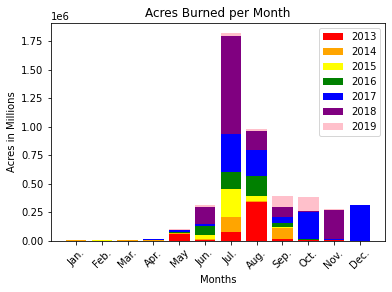

In [35]:
months = list(range(1, 13))
month_labels = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.']
fig, ax = plt.subplots()

ax.bar(months, height=counts_lst[0], color='red', label='2013')
ax.bar(months, height=counts_lst[1], bottom=counts_lst[0], color='orange', label='2014')
ax.bar(months, height=counts_lst[2], bottom=accum_lst[0], color='yellow', label='2015')
ax.bar(months, height=counts_lst[3], bottom=accum_lst[1], color='green', label='2016')
ax.bar(months, height=counts_lst[4], bottom=accum_lst[2], color='blue', label='2017')
ax.bar(months, height=counts_lst[5], bottom=accum_lst[3], color='purple', label='2018')
ax.bar(months, height=counts_lst[6], bottom=accum_lst[4], color='pink', label='2019')

ax.legend()
ax.set_xticks(list(range(1, 13)))
ax.set_xticklabels(month_labels, rotation=45)
        
ax.set_title('Acres Burned per Month')
ax.set_xlabel('Months')
ax.set_ylabel('Acres in Millions')
fig.savefig('stacked-bar.png')

plt.show()

HYPOTHESIS TEST

H0: There is no trend for the number of acres burned by the California Fires over the years 2013-2019.

H1: The number of acres burned by the California Fires has been increasing over the years.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


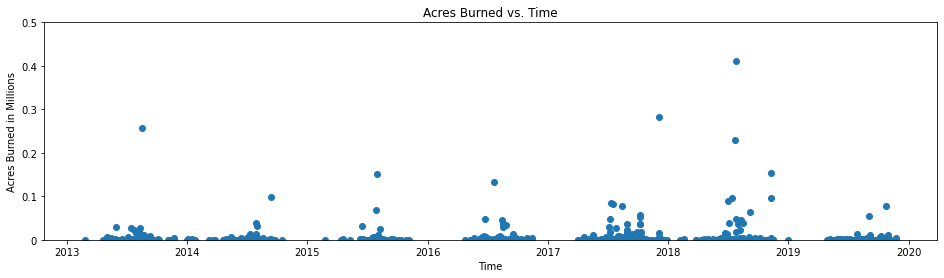

In [36]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(ca_fires_df['StartDate'], ca_fires_df['AcresBurned'])

ax.set_title('Acres Burned vs. Time')
ax.set_xlabel('Time')
ax.set_ylabel('Acres Burned in Millions')
ax.set_ylim(0, 0.5*10**6)
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

plt.show()
fig.savefig('time-vs-acres-scatter.png')

In [37]:
ca_fires_copy = ca_fires_df.copy()
ca_fires_copy = ca_fires_copy.sort_values('StartDate')
# sorts the dataset in chronological order.

In [38]:
time_diff = []
date_lst = list(ca_fires_copy['StartDate'].sort_values())
for idx in range(0, len(date_lst)-1):
    time_diff.append(date_lst[idx+1]-date_lst[0])
# creates a list of time differences from the data point to the first recorded observation.

time_diff.insert(0, timedelta(days=0))
# inserts a 0 since the first day is the initial day.

ca_fires_copy['TimeDifference'] = time_diff
# creates a new column with those calculated differences.

In [39]:
time_diff_int = []
for date in list(ca_fires_copy['TimeDifference']):
    time_diff_int.append(date.days)
# creates a list that changes the timedelta data to integers.

In [40]:
ca_fires_copy['TimeDiffAsInt'] = time_diff_int
# adds the integer list as a new column.

In [41]:
corr, p_value = stats.pearsonr(ca_fires_copy['TimeDiffAsInt'], ca_fires_copy['AcresBurned'])
corr, p_value

(-0.01256766194383122, 0.6372727443945736)

In [42]:
corr, p_value = stats.spearmanr(ca_fires_copy['TimeDiffAsInt'], ca_fires_copy['AcresBurned'])
corr, p_value
# won't use Spearman because it shows a small correlation, but states that it is statistically significant.

(-0.10597020722975467, 6.694812674182656e-05)

In [43]:
mi_lst = []
for year in year_lst:
    mi_lst.append(ca_fires_df[ca_fires_df['StartYear']==year]['MajorIncident'])
# creates a list where each element is the data from the column, 'MajorIncident', of one year.

In [44]:
nk_dct = {}
for bool_lst in mi_lst:
    nk_dct[len(bool_lst)] = sum(bool_lst)
# creates a dictionary where the key is the number of observations in that year and the value is the number of 'MajorIncidents'.

In [45]:
post_dist = []
for n, k in nk_dct.items():
    post_dist.append(stats.distributions.beta(a = 1 + k, b = 1 + n - k))
# runs a posterior distribution for each year.

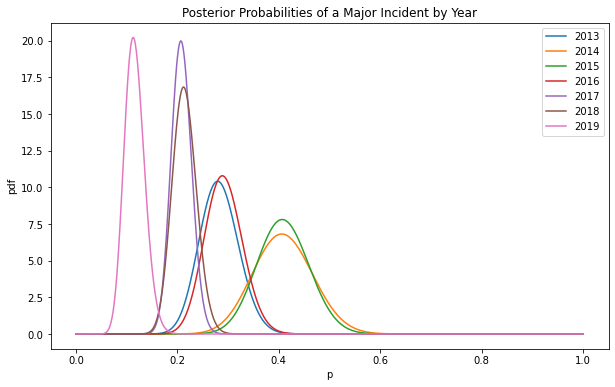

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.linspace(0,1,1000)
year_lst = [2013, 2014, 2015, 2016, 2017, 2018, 2019]
for idx, dist in enumerate(post_dist):
    ax.plot(x, dist.pdf(x), label=f'{year_lst[idx]}')
    ax.legend()
    ax.set_title('Posterior Probabilities of a Major Incident by Year')
    ax.set_xlabel('p')
    ax.set_ylabel('pdf')

fig.savefig('posterior-plots.png')
# plots the posterior distributions for each year.

In [47]:
beta_2013 = post_dist[0]
beta_2019 = post_dist[-1]
# assigns the beta distributions of 2013 and 2019.

In [48]:
sim_2013 = beta_2013.rvs(size=10000)
sim_2019 = beta_2019.rvs(size=10000)
# creates 10,000 simulations from the 'MajorIncident' column.

In [49]:
(sim_2019 > sim_2013).mean()
# calculates what the probability is that P(MajorIncident|2019) > P(MajorIncident|2013).

0.0

There is a very low (basically 0%) chance that the probability that a fire is a major incident in 2019 is greater than that in 2013. Therefore, we can deduce that people's perception of how dangerous the fires are is going down.

In [50]:
beta_2013 = post_dist[0]
beta_2018 = post_dist[-2]
sim_2013 = beta_2013.rvs(size=10000)
sim_2018 = beta_2018.rvs(size=10000)
(sim_2018 > sim_2013).mean()
# does the same thing as above but for 2013 and 2018.

0.0605

Sources:

https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf
-showed me how to create a spatial map.

https://www.sciencemag.org/news/2020/03/us-wildfires-plummeted-2019-experts-say-it-won-t-last
-explained to me why 2019 had so few fires.

https://wildfiretoday.com/2015/11/09/was-the-2014-wildfire-season-in-california-affected-by-climate-change/
-shed some light on why 2014 had a high median for AcresBurned.

https://www.fs.usda.gov/treesearch/pubs/58973
-said they use number of fires and area burned to determine how severe a fire is.

https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python
-helped make gif.